# Market Analysis for Tech Stocks

Ingest, visualize, evaluate risk, and Monte-Carlo simulate prices for some technology stocks: Apple, Google, Microsoft, Amazon. 

Pandas is the most convenient library to extract and analyse the information. Seaborn is a useful tool for complex statistical graphs. Explore different ways to analyze the risk of a stock based on performance history. 

## Goals:

1. Exploring the Apple stock
2. Moving Average of Apple
3. Daily return average of Apple
4. What was the correlation between daily returns of different stocks?
5. Value at Risk
6. Predict future behavior with Monte Carlo Simulations

In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import pandas_datareader
import pandas_datareader.data as web

import datetime as dt

## Download Stock Data of the past 365 Days

In [2]:
list_of_tickers = ['AAPL','GOOG','MSFT','AMZN']

In [3]:
# today
end = dt.date.today()
print('End: ',end)

# one year before today
start = end - dt.timedelta(days=365)
print('Start: ',start)

End:  2020-07-24
Start:  2019-07-25


In [4]:
#Using Yahoo Finance to grab the stock data
try:
    for stock in list_of_tickers:
        f = web.DataReader(stock,'yahoo',start,end)
        f.to_csv('data/stocks/'+stock+'.csv')
except:
    pass

Load up the CSVs into dataframes and concatenate the daily high values.

In [5]:
AAPL = pd.read_csv("data/stocks/AAPL.csv")
GOOG = pd.read_csv("data/stocks/GOOG.csv")
MSFT = pd.read_csv("data/stocks/MSFT.csv")
AMZN = pd.read_csv("data/stocks/AMZN.csv")

# add all high columns together
highdf = pd.concat([AAPL['High'], GOOG['High'], MSFT['High'], AMZN['High']], axis=1, sort=False)

# rename column names
highdf.columns = list_of_tickers

# add date column
highdf = pd.concat([AAPL['Date'],highdf],  axis=1, sort=False)

highdf

,Date,AAPL,GOOG,MSFT,AMZN
0,2019-07-25,209.240005,1141.699951,140.610001,2001.199951
1,2019-07-26,209.729996,1265.550049,141.679993,1950.900024
2,2019-07-29,210.639999,1247.369995,141.509995,1932.229980
3,2019-07-30,210.160004,1234.869995,141.220001,1909.890015
4,2019-07-31,221.369995,1234.000000,140.490005,1899.550049
...,...,...,...,...,...
248,2020-07-20,394.000000,1570.290039,212.300003,3201.360107
249,2020-07-21,397.000000,1586.989990,213.940002,3240.580078
250,2020-07-22,391.899994,1570.000000,212.300003,3150.000000
251,2020-07-23,388.309998,1571.869995,210.919998,3098.270020


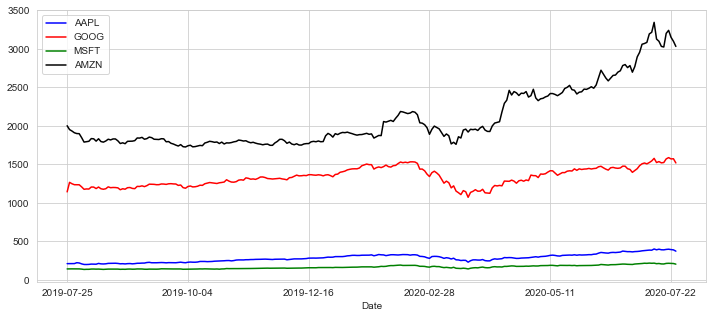

In [6]:
ax = plt.gca()

highdf.plot(kind='line',x='Date',y='AAPL', color='blue',figsize=(12,5),ax=ax)
highdf.plot(kind='line',x='Date',y='GOOG', color='red', ax=ax)
highdf.plot(kind='line',x='Date',y='MSFT', color='green', ax=ax)
highdf.plot(kind='line',x='Date',y='AMZN', color='black', ax=ax)

plt.show()

## 1. Exploring the Apple stock

Thanks to the globals method, Apple's stock data will be stored in the AAPL global variable dataframe. Let's see if that worked.

In [7]:
AAPL.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2019-07-25,209.240005,206.729996,208.889999,207.020004,13909600.0,204.578476
1,2019-07-26,209.729996,207.139999,207.479996,207.740005,17618900.0,205.289978
2,2019-07-29,210.639999,208.440002,208.460007,209.679993,21673400.0,207.207077
3,2019-07-30,210.160004,207.309998,208.759995,208.779999,33935700.0,206.317688
4,2019-07-31,221.369995,211.300003,216.419998,213.039993,69281400.0,210.527466


In [8]:
# Basic stats for Apple's Stock
AAPL.describe()

,High,Low,Open,Close,Volume,Adj Close
count,253.000000,253.000000,253.000000,253.000000,2.530000e+02,253.000000
mean,282.169012,275.505415,278.505059,279.119189,3.539145e+07,278.020963
std,51.106820,49.942719,50.537460,50.617784,1.684201e+07,51.169820
min,198.070007,192.580002,195.410004,193.339996,1.165440e+07,191.059784
25%,242.199997,234.880005,237.520004,239.960007,2.420510e+07,238.030945
50%,280.790009,271.859985,276.279999,275.429993,3.119080e+07,274.686432
75%,319.519989,313.630005,316.269989,316.959991,4.086210e+07,316.092163
max,399.820007,386.970001,396.690002,393.429993,1.067212e+08,393.429993


And that easily, we can make out what the stock's minimum, maximum, and average price was for the last year. 

In [9]:
#Some basic info about the dataframe
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       253 non-null    object 
 1   High       253 non-null    float64
 2   Low        253 non-null    float64
 3   Open       253 non-null    float64
 4   Close      253 non-null    float64
 5   Volume     253 non-null    float64
 6   Adj Close  253 non-null    float64
dtypes: float64(6), object(1)
memory usage: 14.0+ KB


No missing info in the dataframe above, so we can go about our business.

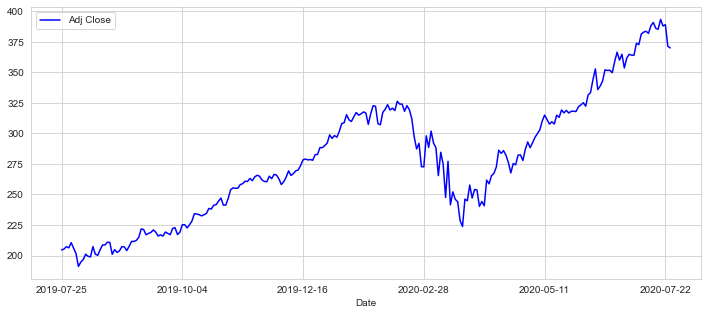

In [10]:
# Plotting the stock's adjusted closing price
AAPL.plot(kind='line',x='Date',y='Adj Close',color='blue',figsize=(12,5))

Similarily, we can plot change in a stock's volume being traded, over time.

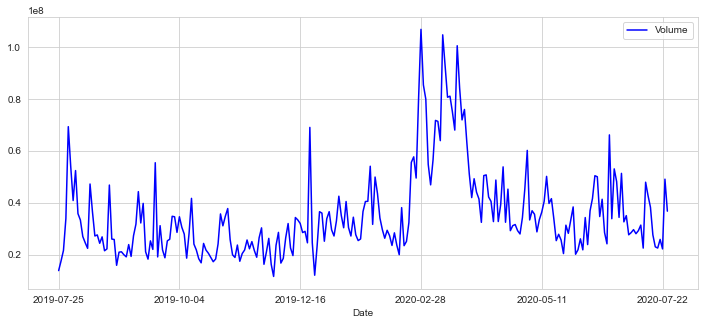

In [11]:
# Plotting the total volume being traded over time
AAPL.plot(kind='line',x='Date',y='Volume',color='blue',figsize=(12,5))

## 2. Moving Average for Apple

Calculate the moving average for stocks over a 10, 20 and 50 day period of time. Add information to the dataframe.

In [12]:
ma_day = [10,20,50]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    
    AAPL[column_name] = AAPL['Adj Close'].rolling(window=ma,center=False).mean()

In [13]:
AAPL.tail()

,Date,High,Low,Open,Close,Volume,Adj Close,MA for 10 days,MA for 20 days,MA for 50 days
248,2020-07-20,394.000000,384.250000,385.670013,393.429993,22579500.0,393.429993,384.662000,373.959998,345.439599
249,2020-07-21,397.000000,386.970001,396.690002,388.000000,25911500.0,388.000000,386.192999,375.416498,346.996999
250,2020-07-22,391.899994,386.410004,386.769989,389.089996,22250400.0,389.089996,386.964999,376.544498,348.478599
251,2020-07-23,388.309998,368.040009,387.989990,371.380005,49081100.0,371.380005,385.801999,377.110498,349.677999
252,2020-07-24,371.619995,356.579987,363.950012,370.015015,36766611.0,370.015015,384.435501,377.369249,350.925299


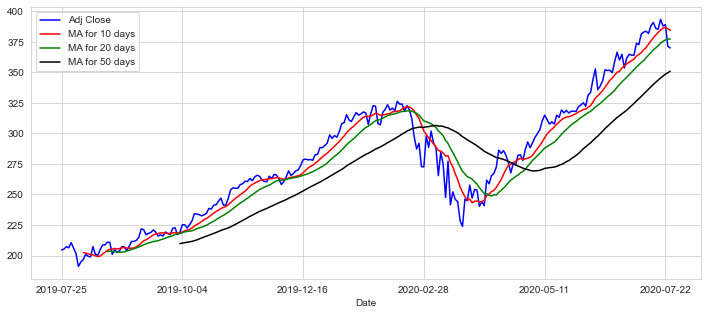

In [14]:
import matplotlib.pyplot as plt

ax = plt.gca()

AAPL.plot(kind='line',x='Date',y='Adj Close', color='blue',figsize=(12,5),ax=ax)
AAPL.plot(kind='line',x='Date',y='MA for 10 days', color='red', ax=ax)
AAPL.plot(kind='line',x='Date',y='MA for 20 days', color='green', ax=ax)
AAPL.plot(kind='line',x='Date',y='MA for 50 days', color='black', ax=ax)

plt.show()

Moving averages for more days have a smoother plot, as they're less reliable on daily fluctuations. So even though, Apple's stock has a slight dip near the start of September, it's generally been on an upward trend since mid-July.

## 3. Daily return average of Apple

In [15]:
# The daily return column can be created by using the percentage change over the adjusted closing price
AAPL['Daily Return'] = AAPL['Adj Close'].pct_change()

In [16]:
AAPL['Daily Return'].tail()

248    0.021074
249   -0.013802
250    0.002809
251   -0.045516
252   -0.003675
Name: Daily Return, dtype: float64

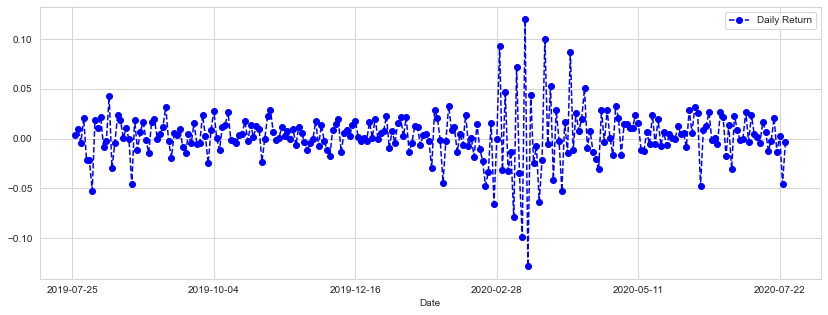

In [17]:
# Plotting the daily return
AAPL.plot(kind='line',x='Date',y='Daily Return',color='blue',figsize=(14,5),linestyle='--',marker='o')

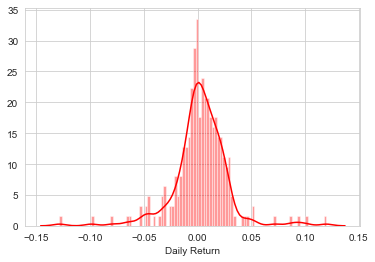

In [18]:
sns.distplot(AAPL['Daily Return'].dropna(),bins=100,color='red')

Positive daily returns seem to be slightly more frequent than negative returns for Apple.

## 4. What was the correlation between daily returns of different stocks?

In [19]:
# load all stock's Adj Close column into a single dataframe
close_df = web.DataReader(list_of_tickers,'yahoo',start,end)['Adj Close']
close_df.tail()

Symbols,AAPL,GOOG,MSFT,AMZN
Date,,,,
2020-07-20,393.429993,1565.719971,211.600006,3196.840088
2020-07-21,388.000000,1558.420044,208.750000,3138.290039
2020-07-22,389.089996,1568.489990,211.750000,3099.909912
2020-07-23,371.380005,1515.680054,202.539993,2986.550049
2020-07-24,370.010010,1508.719971,201.929993,3003.709961


Everything works as expected. 

Just as we did earlier, we can use Pandas' pct_change method to get the daily returns of our stocks.

In [20]:
rets_df = close_df.pct_change()
rets_df.tail()

Symbols,AAPL,GOOG,MSFT,AMZN
Date,,,,
2020-07-20,0.021074,0.033103,0.042981,0.079295
2020-07-21,-0.013802,-0.004662,-0.013469,-0.018315
2020-07-22,0.002809,0.006462,0.014371,-0.012230
2020-07-23,-0.045516,-0.033669,-0.043495,-0.036569
2020-07-24,-0.003689,-0.004592,-0.003012,0.005746


Let's try creating a scatterplot to visualise any correlations between different stocks. First we'll visualise a scatterplot for the relationship between the daily return of a stock to itself.

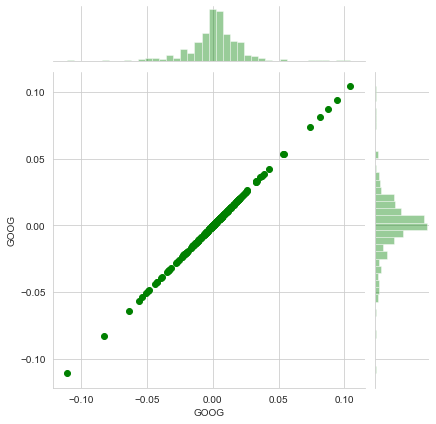

In [21]:
sns.jointplot('GOOG','GOOG',rets_df,kind='scatter',color='green')

As expected, the relationship is perfectly linear because we're trying to correlate something with itself. Now, let's check out the relationship between Google and Apple's daily returns.

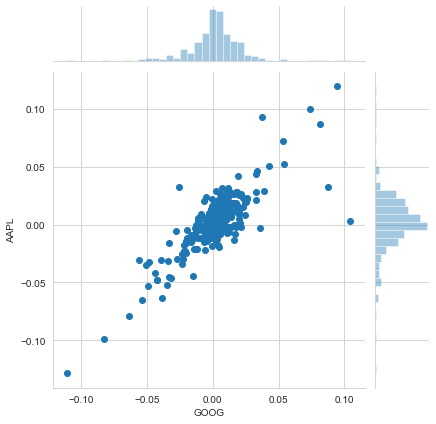

In [22]:
sns.jointplot('GOOG','AAPL',rets_df,kind='scatter')

There seems to be a minor correlation between the two stocks, looking at the figure above. The Pearson R Correlation Coefficient value of 0.45 echoes that sentiment.

But what about other combinations of stocks?

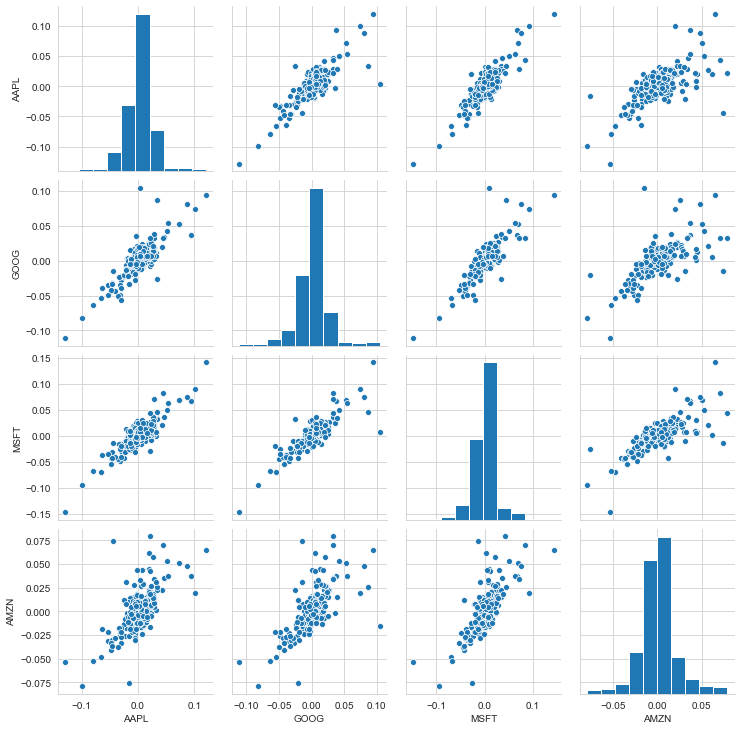

In [23]:
sns.pairplot(rets_df.dropna())

## 5. Value at Risk

The amount of money expected to lose for a given confidence interval. Use the 'Bootstrap' method and the 'Monte Carlo Method' to extract this value.

__Bootstrap Method__

Using this method, calculate the empirical quantiles from a histogram of daily returns. The quantiles help define the confidence interval.

In [24]:
rets = rets_df.dropna()

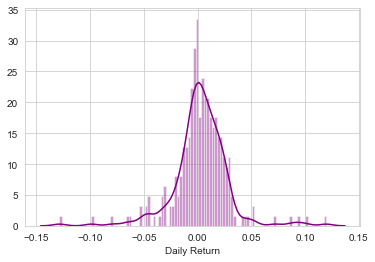

In [25]:
sns.distplot(AAPL['Daily Return'].dropna(),bins=100,color='purple')

To recap, our histogram for Apple's stock looked like the above. And our daily returns dataframe looked like:

In [26]:
rets.head()

Symbols,AAPL,GOOG,MSFT,AMZN
Date,,,,
2019-07-26,0.003478,0.104485,0.008203,-0.015589
2019-07-29,0.009338,-0.008797,-0.002193,-0.015748
2019-07-30,-0.004292,-0.011514,-0.004822,-0.007279
2019-07-31,0.020404,-0.006905,-0.029070,-0.016723
2019-08-01,-0.021639,-0.006304,0.013136,-0.006139


In [27]:
# Using Pandas built in qualtile method
rets['AAPL'].quantile(0.05)

-0.037732801073493395

The 0.05 empirical quantile of daily returns is at -0.0377. This means that with 95% confidence, the worst daily loss will not exceed 3.77%.

## 6. Predict future behavior with Monte Carlo Simulations

More information on Monte Carlo Simulations and stocks: [link](http://www.investopedia.com/articles/07/montecarlo.asp). In short: these simulations are repeated many times, and aggregate the results in the end for some quantifiable value.

In [28]:
days = 365

#delta t
dt = 1/365

mu = rets.mean()['GOOG']

sigma = rets.std()['GOOG']

In [29]:
#Function takes in stock price, number of days to run, mean and standard deviation values
def stock_monte_carlo(start_price,days,mu,sigma):
    
    price = np.zeros(days)
    price[0] = start_price
    
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    for x in range(1,days):
        
        # Shock and drift formulas taken from the Monte Carlo formula
        shock[x] = np.random.normal(loc=mu*dt,scale=sigma*np.sqrt(dt))
        
        drift[x] = mu * dt
        
        # New price = Old price + Old price*(shock+drift)
        price[x] = price[x-1] + (price[x-1] * (drift[x]+shock[x]))
        
    return price

Run the simulation of Google stocks. Open the csv of this stock.

In [30]:
GOOG.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2019-07-25,1141.699951,1120.920044,1137.819946,1132.119995,2209800,1132.119995
1,2019-07-26,1265.550049,1224.000000,1224.040039,1250.410034,4805800,1250.410034
2,2019-07-29,1247.369995,1228.229980,1241.050049,1239.410034,2223700,1239.410034
3,2019-07-30,1234.869995,1223.300049,1225.410034,1225.140015,1453300,1225.140015
4,2019-07-31,1234.000000,1207.764038,1223.000000,1216.680054,1725500,1216.680054


Let's do a 1-year simulation using 50 runs, and plot them.

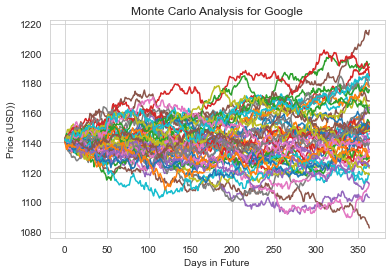

In [31]:
start_price = GOOG.iloc[0,1] # today's high price as starting point

for run in range(50):
    plt.plot(stock_monte_carlo(start_price,days,mu,sigma))

plt.xlabel('Days in Future')
plt.ylabel('Price (USD))')

plt.title('Monte Carlo Analysis for Google')
plt.show()

Now do 10,000 simulations and plot them as histogram.

In [32]:
runs = 10000

simulations = np.zeros(runs)

for run in range(runs):
    simulations[run] = stock_monte_carlo(start_price,days,mu,sigma)[days-1]

Text(0.5, 1.0, 'Final price distribution for Google Stock after 365 days')

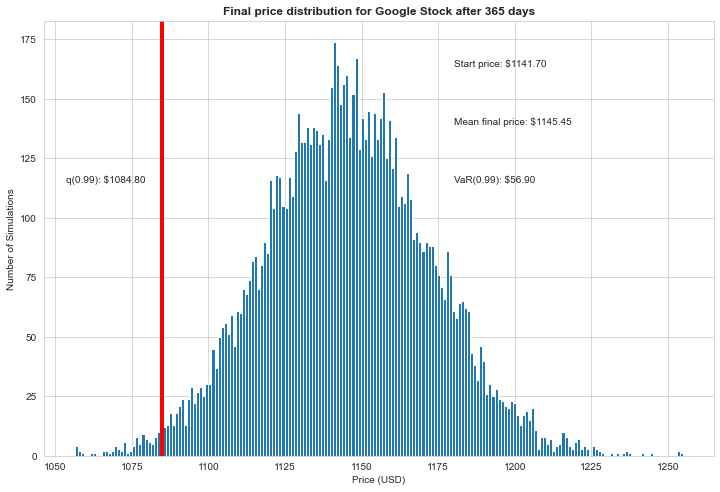

In [33]:
bottom_quantile = np.percentile(simulations,1)

plt.figure(figsize=(12,8))
plt.hist(simulations,bins=200)

plt.figtext(0.6,0.8,s="Start price: $%.2f" %start_price)
plt.figtext(0.6,0.7,"Mean final price: $%.2f" % simulations.mean())
plt.figtext(0.6,0.6,"VaR(0.99): $%.2f" % (start_price - bottom_quantile,))
plt.figtext(0.15,0.6, "q(0.99): $%.2f" % bottom_quantile)

plt.axvline(x=bottom_quantile, linewidth=4, color='r')

plt.xlabel('Price (USD)')
plt.ylabel('Number of Simulations')

plt.title(u"Final price distribution for Google Stock after %s days" %days, weight='bold')

We can infer from this that, Google's stock is pretty stable. The starting price that we had was USD 1,141 and the average final price over 10,000 runs was USD 1,144.

The red bar indicates the value of stock at risk over this year at the desired confidence interval. For a single stock USD 57.70, 99% of the time.